# THIS NOTEBOOK WILL BE USED TO EVALUATE MODELS PERFORMANCE

In [48]:
%load_ext autoreload
%autoreload 2
import os
import torch
import argparse
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from models.shiftnet_model import ShiftNetModel
from options.train_options import TrainOptions 
import util
from skimage.transform import resize
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
dataroot = '/mnt/hdd2/AIM/DAGM/Class4_def/' # ENTER HERE THE PATH YOU WANT TO USE AS DATAROOT
options = '--dataroot {}'.format(dataroot).split(' ')

In [50]:
def get_parser(options=None):
    parser = TrainOptions()
    parser.parse(options=options)
    return parser

In [51]:
parser = get_parser(options=options)

----------------- Options ---------------
                batchSize: 1                             
                    beta1: 0.5                           
               bottleneck: 512                           
          checkpoints_dir: /mnt/hdd2/AIM/checks          
                constrain: MSE                           
           continue_train: False                         
                 dataroot: /mnt/hdd2/AIM/DAGM/Class4_def/	[default: /mnt/hdd2/AIM/DAGM/Class4]
             dataset_mode: aligned_resized               
             display_freq: 10                            
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
display_single_pane_ncols: 0                             
          display_winsize: 256                           
              epoch_count: 1                       

In [52]:
from models import networks
from util.util import *
from models.networks import *

In [53]:
opt = parser.opt

In [54]:
mask = wrapper_gmask(opt)

/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


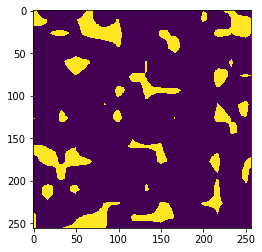

In [55]:
plt.imshow(np.squeeze(mask))

In [56]:
from models.modified_shiftnet_model import ShiftNetModel

In [57]:
shift_model = ShiftNetModel()

In [58]:
opt.name = 'test_modi'

In [59]:
shift_model.initialize(opt)

[CREATING] MODEL
UnetSkipConnectionBlock(
  (model): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace)
    (1): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
)
[CREATED] MODEL
Constraint in netG:
[InnerCos(skip: True ,strength: 1)]
Shift in netG:
[ModifiedInnerShiftTriple(threshold: 0.3125 ,triple_weight 1)]
initialize network with normal
initialize network with normal
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.944 M
[Network D] Total number of parameters : 2.767 M
-----------------------------------------------


In [60]:
shift_model.load_networks('latest')

In [61]:
generator = shift_model.netG

In [62]:
opt.mask_sub_type = 'island'

In [63]:
from data.data_loader import CreateDataLoader

In [64]:
dataset = CreateDataLoader(opt)

CustomDatasetDataLoader
dataset [AlignedDatasetResized] was created


In [65]:
def scale(img):
    img-=img.min()

    return img/img.max()

def tensor2numpy(t):
    img = np.squeeze(t.numpy())
    img = img.transpose((1, 2, 0))
    img = scale(img)
    return img

In [66]:
import util
from util.util import OptimizerMask, create_masks

In [67]:
masks_resized, masks = create_masks(opt, N=1000)

/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [68]:
masks_resized.shape

(1000, 64, 64)

In [69]:
opti_mask = OptimizerMask(masks_resized.reshape(masks_resized.shape[0], -1))

In [70]:
opti_mask.get_iou()

In [71]:
opti_mask.solve()

0.162841796875
0.247314453125
0.353515625
0.4365234375
0.49560546875
0.541015625
0.59765625
0.63671875
0.6689453125
0.70654296875
0.7353515625
0.762939453125
0.7861328125
0.816162109375
0.8466796875
0.86376953125


In [72]:
indexes = opti_mask.indexes
indexes

array([648, 651, 856, 776, 465, 657,  96, 288, 475, 505,  77, 703, 123,
       633,  35, 118, 891])

In [73]:
full = opti_mask.get_masks()

In [74]:
full = resize(full, (256, 256))

In [75]:
full[full > 0] = 1

In [76]:
full = full.reshape((1, 1, 256, 256))
full.shape

(1, 1, 256, 256)

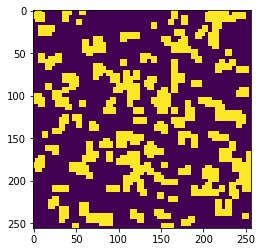

In [77]:
plt.imshow(np.squeeze(full))

In [78]:
sampled_masks = masks[indexes]

In [79]:
masks2use = sampled_masks

In [80]:
full = (masks2use.mean(0) == 0).astype(np.int)

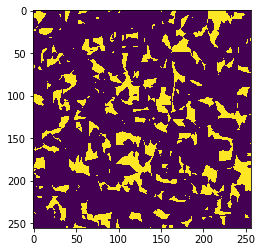

In [81]:
plt.imshow(np.squeeze(full))

In [82]:
for data in dataset:
    break
shift_model.set_input(data)
out = []

shift_model.set_input_with_mask(data, torch.ByteTensor(full).cuda())

shift_model.forward()

output = shift_model.fake_B

output = tensor2numpy(output.cpu().detach())

out.append(output)    

for i in range(len(masks2use)):
    
    shift_model.set_input_with_mask(data, torch.ByteTensor(masks2use[i]).cuda())

    shift_model.forward()

    output = shift_model.fake_B

    output = tensor2numpy(output.cpu().detach())

    out.append(output)

    


In [83]:
img = tensor2numpy(data['B'])

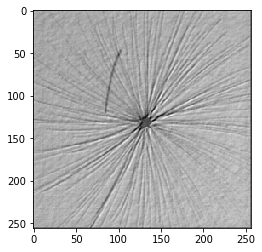

In [84]:
plt.imshow(img)

In [85]:
out = np.array(out)
out.shape

(18, 256, 256, 3)

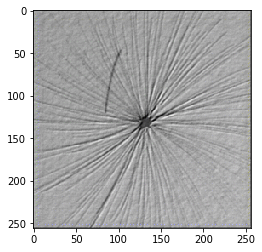

In [86]:
plt.imshow(out.mean(0))

In [87]:
masks_eval = np.concatenate([full[np.newaxis], masks2use], axis=0)

In [88]:
from util.poisson_blending import blend

In [ ]:
#blend(img_target, img_source, img_mask)

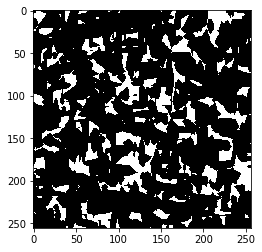

In [ ]:
sum_mask = np.zeros_like(out[0])
h = np.zeros_like(out[0])
blends = []
for m, pred in zip(masks_eval, out):
    m = np.squeeze(m)
    sum_mask[m == 1] += 1
    plt.imshow(sum_mask)
    plt.show()
    blended = blend(pred, img, m)
    blends.append(blended)
    plt.imshow(blended)
    plt.show()
    h[m == 1] += pred[m == 1]
    plt.imshow(h)
    plt.show()

In [90]:
normalized = h / sum_mask

In [91]:
img = tensor2numpy(data['B'])

In [92]:
diff = np.abs(img - normalized)
diff.shape

(256, 256, 3)

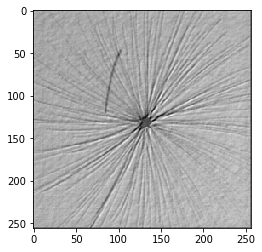

In [93]:
plt.imshow(img)

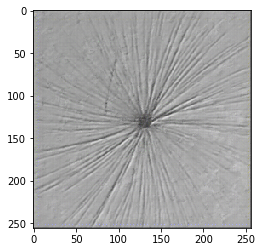

In [94]:
plt.imshow(normalized)

In [95]:
diff/=diff.max()
diff.shape

(256, 256, 3)

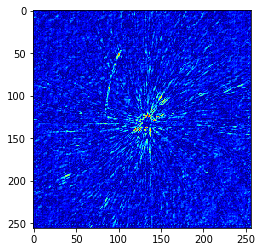

In [96]:
plt.imshow(diff.mean(-1), cmap='jet')